#Final Assignment - NYC Citi Bike Trips

**Overview**


Citi Bike is the nation's largest bike share program, with 10,000 bikes and 600 stations across Manhattan, Brooklyn, Queens, and Jersey City. This dataset includes Citi Bike trips since Citi Bike launched in September 2013 and is updated daily. The data has been processed by Citi Bike to remove trips that are taken by staff to service and inspect the system, as well as any trips below 60 seconds in length, which are considered false starts.

This public dataset is hosted in Google BigQuery and is included in BigQuery's 1TB/mo of free tier processing. This means that each user receives 1TB of free BigQuery processing every month, which can be used to run queries on this public dataset. Watch this short video to learn how to get started quickly using BigQuery to access public datasets.

###Notebook Setup

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
import geopy.geocoders
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.distance import vincenty
from geopy import distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

###Analyze BigQuery Dataset

**What are the most popular Citi Bike stations?**

In [2]:
%%bigquery --project msds434-cohort-analysis-mvp
SELECT
  start_station_name,
  start_station_latitude,
  start_station_longitude,
  COUNT(*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  1,
  2,
  3
ORDER BY
  num_trips DESC
LIMIT
  10

,start_station_name,start_station_latitude,start_station_longitude,num_trips
0,E 17 St & Broadway,40.737050,-73.990093,291615
1,Lafayette St & E 8 St,40.730287,-73.990765,277060
2,W 21 St & 6 Ave,40.741740,-73.994156,275348
3,West St & Chambers St,40.717548,-74.013221,260911
4,Pershing Square North,40.751873,-73.977706,246181
5,Broadway & E 14 St,40.734546,-73.990741,244420
6,Broadway & E 22 St,40.740343,-73.989551,237394
7,8 Ave & W 33 St,40.751551,-73.993934,223970
8,W 20 St & 11 Ave,40.746745,-74.007756,211840
9,Broadway & W 24 St,40.742354,-73.989151,211713


In reviewing the 2013-2015 dataset, we can better visualize the New York Citi bike stations that are most popular. The results above categorize this interest by look to the station in which the user started their ride.

**What are the most popular routes by subscriber type?**

In [33]:
%%bigquery --project msds434-cohort-analysis-mvp
SELECT
  usertype, 
  CONCAT(start_station_name, " to ", end_station_name) as route, 
  COUNT(*) as num_trips,
  ROUND(AVG(cast(tripduration as int64) / 60),2) as duration
FROM 
  `bigquery-public-data.new_york.citibike_trips`
GROUP BY
  start_station_name, end_station_name, usertype
ORDER BY 
  num_trips DESC
LIMIT 10

,usertype,route,num_trips,duration
0,Customer,Central Park S & 6 Ave to Central Park S & 6 Ave,40009,50.89
1,Customer,Grand Army Plaza & Central Park S to Grand Arm...,15234,52.99
2,Customer,Centre St & Chambers St to Centre St & Chamber...,12466,35.65
3,Subscriber,W 21 St & 6 Ave to 9 Ave & W 22 St,11594,5.35
4,Customer,Broadway & W 60 St to Broadway & W 60 St,10816,52.36
5,Subscriber,W 21 St & 6 Ave to W 22 St & 10 Ave,10451,6.95
6,Subscriber,E 7 St & Avenue A to Lafayette St & E 8 St,9639,5.59
7,Subscriber,West Thames St to Vesey Pl & River Terrace,9218,6.67
8,Subscriber,W 17 St & 8 Ave to 8 Ave & W 31 St,8760,6.43
9,Subscriber,E 43 St & Vanderbilt Ave to W 41 St & 8 Ave,8743,7.04


We also wanted to understand frequent patterns from our Citi bike subscribers. The results above aim to describe the most popular routes by subscriber type. Within this dataset, “Subscribers” are Citibike members while “Customers” are one-off users. The table above shows the tops bike route habits for each member type. 

**What are the top routes by gender?**

In [35]:
%%bigquery --project msds434-cohort-analysis-mvp
SELECT
  CONCAT(start_station_name, " to ", end_station_name) AS route,
  COUNT(*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
WHERE
  gender = "female"
  AND CAST(starttime AS string) LIKE '2016%'
GROUP BY
  start_station_name,
  end_station_name
ORDER BY
  num_trips DESC
LIMIT
  5

,route,num_trips
0,W 21 St & 6 Ave to W 22 St & 10 Ave,942
1,N 6 St & Bedford Ave to Wythe Ave & Metropolit...,905
2,W 21 St & 6 Ave to 9 Ave & W 22 St,809
3,Wythe Ave & Metropolitan Ave to N 6 St & Bedfo...,769
4,W 22 St & 10 Ave to W 21 St & 6 Ave,765


After understanding frequent routes by member type, it was also suggested that this be evaluated by gender. The table above shows the popular routes taken by both male and female Citibike users. 

###Analyze 2016 Citi Bike Data

With the full Citi Bike dataset being larger, a subset of 2016 was generated for further exploratory research. The details below show the how the sample count of around 1,000,000 records was created. 

In [0]:
project_id = 'msds434-cohort-analysis-mvp'

In [44]:
from google.cloud import bigquery

client = bigquery.Client(project='msds434-cohort-analysis-mvp')

sample_count = 1000000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `msds434-cohort-analysis-mvp.citibikenyc_analysis.citibikenyc_2016`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `msds434-cohort-analysis-mvp.citibikenyc_analysis.citibikenyc_2016`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 10262758 rows


In [45]:
df.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,1.000309e+06,1.000309e+06,1.000309e+06,1.000309e+06,1.000309e+06,1.000309e+06,1.000309e+06,1.000309e+06,875245.000000
mean,9.983013e+02,9.975767e+02,4.073762e+01,-7.398665e+01,9.842912e+02,4.073698e+01,-7.398630e+01,2.064772e+04,1977.651332
std,9.825605e+03,1.135670e+03,2.352822e-02,1.628141e-02,1.126608e+03,1.102889e-01,1.964002e-01,3.489891e+03,11.662016
min,6.100000e+01,7.200000e+01,4.064668e+01,-7.401713e+01,7.200000e+01,0.000000e+00,-7.405757e+01,1.452900e+04,1885.000000
25%,3.870000e+02,3.340000e+02,4.072087e+01,-7.399810e+01,3.300000e+02,4.072066e+01,-7.399852e+01,1.760400e+04,1970.000000
50%,6.430000e+02,4.580000e+02,4.073902e+01,-7.398860e+01,4.570000e+02,4.073818e+01,-7.398889e+01,2.077800e+04,1980.000000
75%,1.095000e+03,5.360000e+02,4.075467e+01,-7.397769e+01,5.330000e+02,4.075323e+01,-7.397771e+01,2.359400e+04,1987.000000
max,4.504481e+06,3.436000e+03,4.080421e+01,-7.392989e+01,3.435000e+03,4.080421e+01,0.000000e+00,2.731600e+04,2000.000000


####Data Clean Up

**Missing Data**: From the data sample, it is important too understand which fields may have missing information.

In [48]:
sample_df = df
#Percentage of missing data.
def missing_data(sample_df):
    total = sample_df.isnull().sum().sort_values(ascending=False)
    percent = (sample_df.isnull().sum()/sample_df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(sample_df)

,Total,Percent
birth_year,125064,12.502537
gender,0,0.000000
usertype,0,0.000000
bikeid,0,0.000000
end_station_longitude,0,0.000000
end_station_latitude,0,0.000000
end_station_name,0,0.000000
end_station_id,0,0.000000
start_station_longitude,0,0.000000
start_station_latitude,0,0.000000


As we use the available informaton to establish a model that predicts how long a trip will take given a starting point and destination, it will be important to remember that not ever user provides their age. 

**Data Formatting:** In continuing to prep our Citi Bike data, establish formats will especially help will visualizaton needs. 

In [51]:
#Ensure data is formatted correctly to avoid errors in the visuals
sample_df['starttime'] = to_datetime(sample_df['starttime'])
sample_df['stoptime'] = to_datetime(sample_df['stoptime'])
sample_df['start_station_name'] = sample_df['start_station_name'].astype('category')
sample_df['end_station_name'] = sample_df['end_station_name'].astype('category')
sample_df['usertype'] = sample_df['usertype'].astype('category')
sample_df['gender'] = sample_df['gender'].astype('category')
round(sample_df.describe(),2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,1000309.0,1000309.00,1000309.00,1000309.00,1000309.00,1000309.00,1000309.00,1000309.00,875245.00
mean,998.3,997.58,40.74,-73.99,984.29,40.74,-73.99,20647.72,1977.65
std,9825.6,1135.67,0.02,0.02,1126.61,0.11,0.20,3489.89,11.66
min,61.0,72.00,40.65,-74.02,72.00,0.00,-74.06,14529.00,1885.00
25%,387.0,334.00,40.72,-74.00,330.00,40.72,-74.00,17604.00,1970.00
50%,643.0,458.00,40.74,-73.99,457.00,40.74,-73.99,20778.00,1980.00
75%,1095.0,536.00,40.75,-73.98,533.00,40.75,-73.98,23594.00,1987.00
max,4504481.0,3436.00,40.80,-73.93,3435.00,40.80,0.00,27316.00,2000.00


**Disqualified Rides**: Because some rider may have experienced issues with their first bike, it would be wise to eliminate any rides that are under a minute and a half because they were not completed. In this scenario, typically users will redock and checkout a new bike.

In [57]:
#Confirm Hypothesis 
df_bikenum = pd.DataFrame()
df_bikenum['first_bike'] = sample_df[sample_df['tripduration'] < 90]['start_station_name'] 
df_bikenum['second_bike'] = sample_df[sample_df['tripduration'] < 90]['end_station_name']
df_bikenum.head()

,first_bike,second_bike
373,1 Ave & E 15 St,1 Ave & E 18 St
576,Lorimer St & Broadway,Leonard St & Boerum St
647,Leonard St & Boerum St,Lorimer St & Broadway
698,Franklin St & W Broadway,Leonard St & Church St
1108,Water - Whitehall Plaza,Old Slip & Front St


In [0]:
#Eliminate Bike Rides Under 90 seconds
#Clear up enviornment and drop double count
del(df_bikenum)
sample_df = sample_df.drop(df.index[(df['tripduration'] < 90) & 
                          (sample_df['start_station_latitude'] == sample_df['end_station_latitude'])])

###Explore Key Variables

####Top 5 Citi Bike Stations

To continue to analyze our cleaned up data, let's analyze which are the top 5 station of this sample dataset.

In [0]:
#Data for Top 5 Stations visual
top5 = pd.DataFrame() 
top5['station']=sample_df['start_station_name'].value_counts().head().index
top5['number_of_starts']=sample_df['start_station_name'].value_counts().head().values
top5['station'] = top5['station'].cat.remove_unused_categories()
top5['station'] = top5['station'].astype('object')
#top5.sort_values(by = 'number_of_starts', ascending = False)

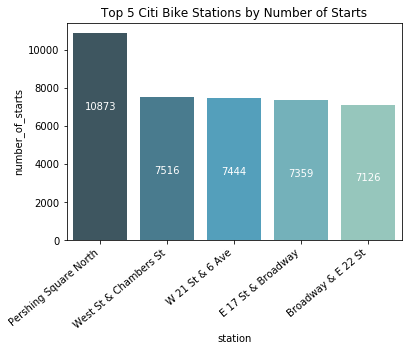

In [69]:
#Plot for Part 1: Top 5 Stations
ax = sns.barplot('station', 'number_of_starts', data = top5, palette="GnBu_d")
ax.set_title('Top 5 Citi Bike Stations by Number of Starts', fontsize = 12)
rcParams['figure.figsize'] = 12,7
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
for index, row in top5.iterrows():
    ax.text(index,row['number_of_starts']-4000,row['number_of_starts'], 
            color='white', ha="center", fontsize = 10)
plt.show()

###Trip Duration by User Type

Other information that could be important for our prediction model will be the how each user type interacts with Citi bike.

In [0]:
#Calculate trip duration
TD_user = pd.DataFrame()
TD_user['averagetripduration'] = round(sample_df.groupby('usertype')['tripduration'].mean(),2)
TD_user = TD_user.reset_index()
TD_user['usertype'] = TD_user['usertype'].astype('object')

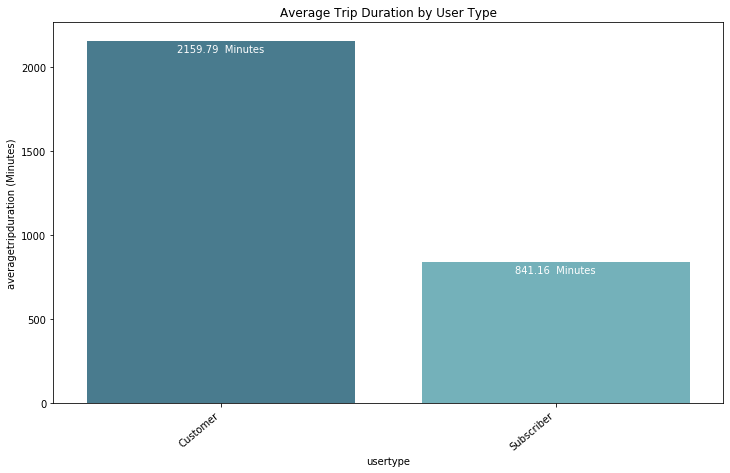

In [76]:
#Average trip Duration per User Type
ax2 = sns.barplot('usertype', 'averagetripduration', data = TD_user,palette="GnBu_d")
ax2.set_title('Average Trip Duration by User Type')
#rcParams['figure.figsize'] = 12,7
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=40, ha = 'right')
ax2.set_ylabel('averagetripduration (Minutes)')
for index, row in TD_user.iterrows():
    ax2.text(index,row['averagetripduration']-70,(str(row['averagetripduration'])+"  Minutes"), 
             color='white', ha="center", fontsize = 10)
plt.show()

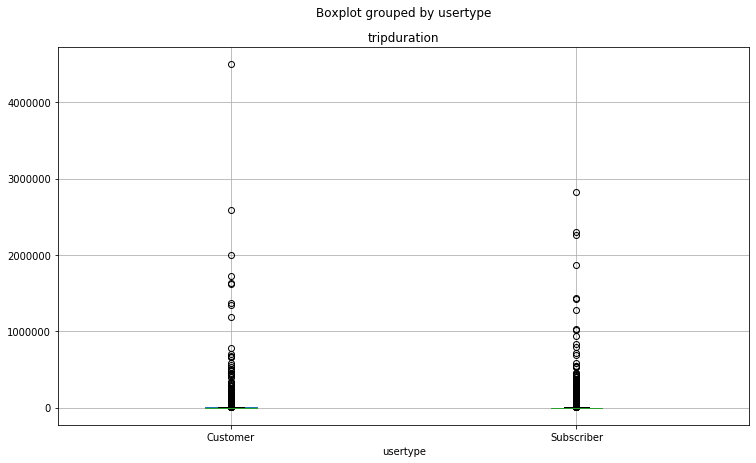

In [78]:
#Boxplots are more informative to visualize breakdown of data
del(TD_user)
df.boxplot('tripduration', by = 'usertype')
plt.show()

####Most Popular Trips

Research also indicates that it could be wise to assess the most poopular trips for our dataset.

In [0]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = sample_df.groupby(['start_station_name','end_station_name']).size().reset_index(name = 'numberoftrips')
trips_df = trips_df.sort_values('numberoftrips', ascending = False)
trips_df["start_station_name"] = trips_df["start_station_name"].astype(str)
trips_df["end_station_name"] = trips_df["end_station_name"].astype(str)
trips_df["trip"] = trips_df["start_station_name"] + " to " + trips_df["end_station_name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start_station_name', "end_station_name"], axis = 1)
trips_df = trips_df.reset_index()
#trips_df.head()

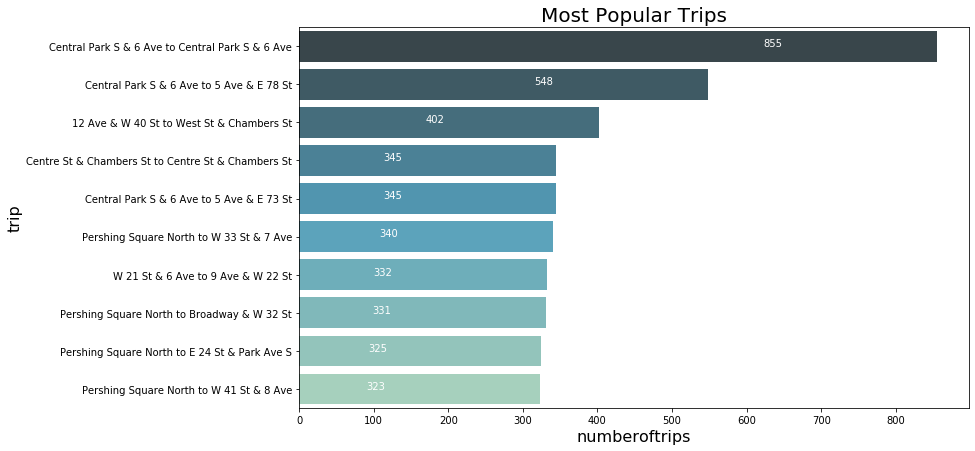

In [83]:
ax3 = sns.barplot('numberoftrips','trip', data = trips_df,palette="GnBu_d")
ax3.set_title('Most Popular Trips', fontsize = 20)
ax3.set_ylabel("trip",fontsize=16)
ax3.set_xlabel("numberoftrips",fontsize=16)
for index, row in trips_df.iterrows():
    ax3.text(row['numberoftrips']-220,index,row['numberoftrips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

####Rider Performance by Age and Gender

Knowing how age and gender coorelates to performance will also be helpful for future modeling efforts

In [0]:
#Drop the tail end of birth years 2 standard deviations below the mean
#df['Birth Year'].mean()-(2*df['Birth Year'].std())
sample_df = sample_df.drop(sample_df.index[(sample_df['birth_year'] < 1956)])

In [0]:
#Combine coordinates to calculate distance 
sample_df['start_coordinates'] = list(zip(sample_df['start_station_latitude'], sample_df['start_station_longitude']))
sample_df['end_coordinates'] = list(zip(sample_df['end_station_latitude'], sample_df['end_station_longitude']))

In [0]:
#Replace missing birth year by median based on speed and gender
sample_df['birth_year'] = sample_df.groupby(['gender','start_station_id'])['birth_year'].transform(lambda x: x.fillna(x.median()))

In [0]:
#if there are still a few nulls, drop these
sample_df = sample_df.dropna(subset=['birth_year'])

In [0]:
#Calculate age and drop circular/roundtrips
sample_df['age'] = 2020 - sample_df['birth_year']
sample_df['age'] = sample_df['age'].astype(int)

In [0]:
 dist = [] 
 for i in range(len(sample_df)): 
   dist.append(geopy.distance.vincenty(sample_df.iloc[i]['start_coordinates'],sample_df.iloc[i]['end_coordinates']).miles)
if (i%1000000==0): 
  print(i)

In [0]:
sample_df['distance'] = dist

In [0]:
sample_df = sample_df.drop(sample_df.index[(sample_df['distance'] == 0)])

In [0]:
#df[df['Trip Duration']<90]
#2. Followed the same reasoning as behind Birth Year. People in similar locations tend to also work in a similar industry or location
sample_df['distance'] = sample_df.groupby(['gender','start_station_id'])['distance'].transform(lambda x: x.fillna(x.median()))

In [0]:
sample_df['minutes'] = sample_df['tripduration']/60

In [0]:
sample_df['min_mile'] = round(sample_df['minutes']/sample_df['distance'], 2)
sample_df['mile_hour'] = round(sample_df['distance']/(sample_df['minutes']/60),2)

In [142]:
#Check for Data Integrity
round(sample_df.describe(),2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,age,distance,minutes,min_mile,mile_hour
count,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00,933665.00
mean,973.57,983.66,40.74,-73.99,973.80,40.74,-73.99,20662.90,1978.79,41.20,1.15,16.23,17.02,5.58
std,9965.54,1125.88,0.02,0.02,1119.53,0.02,0.02,3490.52,9.90,9.89,0.84,166.09,243.49,1.92
min,61.00,72.00,40.65,-74.02,72.00,40.65,-74.06,14529.00,1956.00,20.00,0.02,1.02,3.78,0.00
25%,386.00,332.00,40.72,-74.00,330.00,40.72,-74.00,17620.00,1971.50,33.00,0.57,6.43,8.82,4.46
50%,636.00,458.00,40.74,-73.99,457.00,40.74,-73.99,20803.00,1981.00,39.00,0.91,10.60,10.63,5.65
75%,1075.00,533.00,40.75,-73.98,532.00,40.75,-73.98,23609.00,1987.00,48.00,1.48,17.92,13.44,6.80
max,4504481.00,3436.00,40.80,-73.93,3435.00,40.80,-73.93,27316.00,2000.00,64.00,9.68,75074.68,155107.45,15.89


Continue the data clean.

In [0]:
#Let's check for data integrity to make sure all the numbers look as expected. Only numerical data included
sample_df = sample_df[sample_df['distance'] < 30]

In [0]:
#as well as 
sample_df = sample_df[sample_df['mile_hour']<20]
sample_df = sample_df[sample_df['mile_hour']> (sample_df['mile_hour'].mean()-(2*sample_df['mile_hour'].std()))]

In [0]:
#drop unknown gender from sample set
cleaned_df = sample_df.loc[sample_df['gender'].isin(['female','male'])]

In [0]:
cleaned_df = cleaned_df.drop(cleaned_df.index[(cleaned_df['tripduration'] > 10800)])

In [176]:
round(cleaned_df.describe(),2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,age,distance,minutes,min_mile,mile_hour
count,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00,804632.00
mean,716.97,961.29,40.74,-73.99,945.43,40.74,-73.99,20734.29,1978.98,41.02,1.15,11.95,11.05,5.94
std,499.70,1111.24,0.02,0.02,1099.37,0.02,0.02,3487.40,10.15,10.15,0.84,8.33,3.82,1.64
min,61.00,72.00,40.65,-74.02,72.00,40.65,-74.05,14529.00,1956.00,20.00,0.04,1.02,3.78,1.75
25%,361.00,334.00,40.72,-74.00,330.00,40.72,-74.00,17691.00,1971.00,33.00,0.56,6.02,8.62,4.85
50%,575.00,458.00,40.74,-73.99,456.00,40.74,-73.99,20944.00,1981.00,39.00,0.90,9.58,10.23,5.87
75%,931.00,530.00,40.75,-73.98,528.00,40.75,-73.98,23657.00,1987.00,49.00,1.47,15.52,12.38,6.96
max,8672.00,3436.00,40.80,-73.93,3435.00,40.80,-73.93,27316.00,2000.00,64.00,8.19,144.53,34.38,15.89


In [177]:
cleaned_df.gender.unique()

[female, male]
Categories (2, object): [female, male]

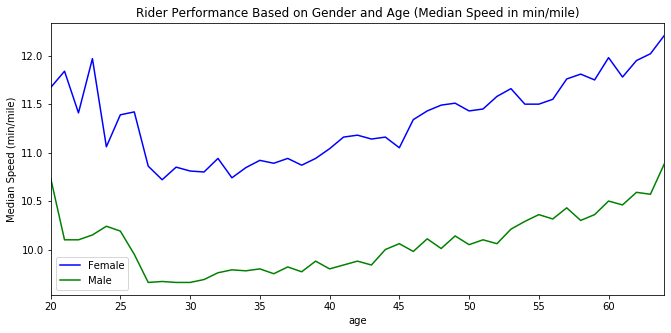

In [178]:
#Rider performance by age and Gender in Min/Mile 
fig, ax4 = plt.subplots(figsize=(11,5))
cleaned_df.groupby(['age','gender']).median()['min_mile'].unstack().plot(ax=ax4, color ="bg")
ax4.legend(['Female','Male'])
plt.ylabel('Median Speed (min/mile)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in min/mile)')
plt.show()

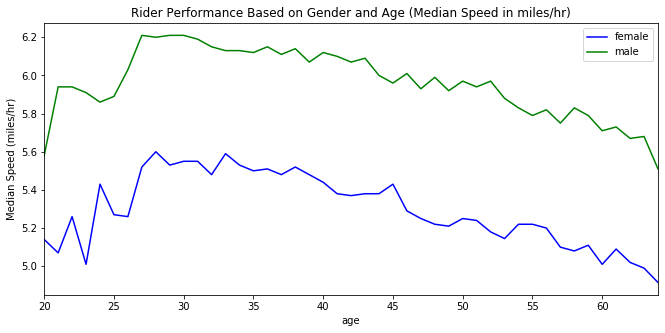

In [179]:
#Rider performance by age and Gender in Miles/hr
fig1, ax5 = plt.subplots(figsize=(11,5))
cleaned_df.groupby(['age','gender']).median()['mile_hour'].unstack().plot(ax=ax5,color ="bg")
ax5.legend(['female', 'male'])
plt.ylabel('Median Speed (miles/hr)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in miles/hr)')
plt.show()

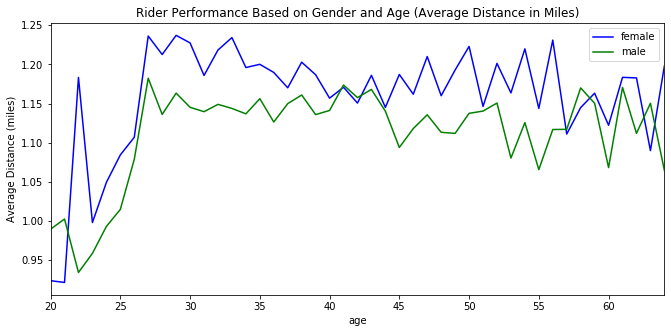

In [180]:
#Rider performance by age and Gender in Averge Distance
fig2, ax6 = plt.subplots(figsize=(11,5))
cleaned_df.groupby(['age','gender']).mean()['distance'].unstack().plot(ax=ax6,color ="bg")
ax6.legend(['female', 'male'])
plt.ylabel('Average Distance (miles)')
plt.title('Rider Performance Based on Gender and Age (Average Distance in Miles)')
plt.show()

##Predictive Modeling

Now that the data is cleaned an dunderstood, we can begin to build a model that predicts how long a trip will take given a starting point and destination.

In [0]:
model_df = cleaned_df

In [0]:
#create a random sample 
model_df_sample = model_df.sample(frac = 0.1, random_state = 0)

In [190]:
model_df_sample.columns.values

array(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid',
       'usertype', 'birth_year', 'gender', 'start_coordinates',
       'end_coordinates', 'age', 'distance', 'minutes', 'min_mile',
       'mile_hour'], dtype=object)

In [0]:
def drop_data(model_df):
    model_df = model_df.drop(['tripduration','stoptime','start_station_id','start_station_latitude','start_station_longitude',
                  'start_coordinates','end_station_id', 'end_station_latitude', 'end_station_longitude', 
                  'end_coordinates','bikeid', 'start_station_name','birth_year','end_station_name','min_mile',
                  'mile_hour','age'], axis = 1)
    return model_df

df_basemodel = drop_data(model_df_sample)

In [0]:
df_basemodel = df_basemodel.drop('starttime', axis =1)

In [0]:
#Dummify categorical data and avoid dummy variable trap
df_basemodel = pd.get_dummies(df_basemodel, drop_first = True)

In [195]:
#review correlation
df_basemodel.corr().loc[:,'minutes']

distance               0.861207
minutes                1.000000
usertype_Subscriber   -0.068572
gender_male           -0.100515
gender_unknown              NaN
Name: minutes, dtype: float64

In [0]:
#Train Test Split
#Predictor variable
X = df_basemodel.iloc[:,1:]
#Target variable
y = df_basemodel.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [203]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.744165464813784

In [206]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value enco

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                 6.324e+04
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        04:58:35   Log-Likelihood:                -35579.
No. Observations:               64370   AIC:                         7.117e+04
Df Residuals:                   64366   BIC:                         7.120e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4506      0.028    -15.931      0.000      -0.506      -0.395
minutes                 0.0869      0.000    435.183      0.000       0.087       0.087
usertype_Subscriber     0.4757      0.028     17.005      0.000       0.421       0.530
gender_male             0.1133      0.004     29.263      0.000       0.106       0.121
gender_unknown               0          0        nan        nan           0           0
==============================================================================
Omnibus:                    12592.127   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           376784.896
Skew:                          -0.179   Prob(JB):                         0.00
Kurtosis:                      14.847   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Continue to refine this model by reviewing date. 
*   December - Feb. = Winter
*   March - May = Spring
*   June - Aug. = Summer
*   Sept. - Nov. = Fall

In [0]:
model_2_df = cleaned_df

In [0]:
def get_date_info(model_2_df):
    model_2_df['d_week'] = model_2_df['starttime'].dt.dayofweek
    model_2_df['m_yr'] = model_2_df['starttime'].dt.month
    model_2_df['ToD'] = model_2_df['starttime'].dt.hour

    model_2_df['d_week'] = (model_2_df['d_week']<5).astype(int)

    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[12,1,2], value = 0)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[3,4,5], value = 1)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[6,7,8], value = 2)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[9,10,11], value = 3)
    
    model_2_df['ToD'] = pd.cut(model_2_df['ToD'], bins=[-1, 5, 9, 14, 20, 25], labels=['Night','Morning','Afternoon','Evening','Night1'])
    model_2_df['ToD'] = model_2_df['ToD'].replace(to_replace='Night1', value = 'Night')
    model_2_df['ToD'] = model_2_df['ToD'].cat.remove_unused_categories()
    
    model_2_df['m_yr'] = model_2_df['m_yr'].astype('category')
    model_2_df['d_week'] = model_2_df['d_week'].astype('category')

    return(model_2_df)

In [0]:
#Dataset for the second model
df_model2 = drop_data(model_df_sample)
df_model2 = get_date_info(df_model2)
df_model2 = df_model2.drop('starttime', axis =1)

In [0]:
#Dummify categorical data and avoid dummy variable trap
df_model2 = pd.get_dummies(df_model2, drop_first = True)

In [0]:
#Predictor variable
X = df_model2.iloc[:,1:]
#Target variable
y = df_model2.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [213]:
#Fit Linear Regression and check accuracy using sklearn
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.7485725654554233

In [215]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 1.937e+04
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        05:08:28   Log-Likelihood:                -35076.
No. Observations:               64370   AIC:                         7.017e+04
Df Residuals:                   64359   BIC:                         7.027e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4448      0.029    -15.282      0.000      -0.502      -0.388
minutes                 0.0871      0.000    437.160      0.000       0.087       0.087
usertype_Subscriber     0.4369      0.028     15.683      0.000       0.382       0.491
gender_male             0.1107      0.004     28.773      0.000       0.103       0.118
gender_unknown       8.766e-17   1.77e-17      4.942      0.000    5.29e-17    1.22e-16
d_week_1                0.0496      0.004     11.797      0.000       0.041       0.058
m_yr_1                  0.0079      0.006      1.389      0.165      -0.003       0.019
m_yr_2                 -0.0073      0.006     -1.334      0.182      -0.018       0.003
m_yr_3                 -0.0042      0.006     -0.657      0.511      -0.017       0.008
ToD_Morning             0.0681      0.006     10.785      0.000       0.056       0.080
ToD_Afternoon          -0.0576      0.006     -9.128      0.000      -0.070      -0.045
ToD_Evening            -0.0196      0.006     -3.349      0.001      -0.031      -0.008
==============================================================================
Omnibus:                    12600.453   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           381246.716
Skew:                          -0.171   Prob(JB):                         0.00
Kurtosis:                      14.918   Cond. No.                     1.42e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.93e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see some improvement in our model.